In [1]:
import heapq
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import copy

Solving puzzle...

Solution found!
Time taken: 0.001 seconds
Number of moves: 4
Nodes expanded: 5


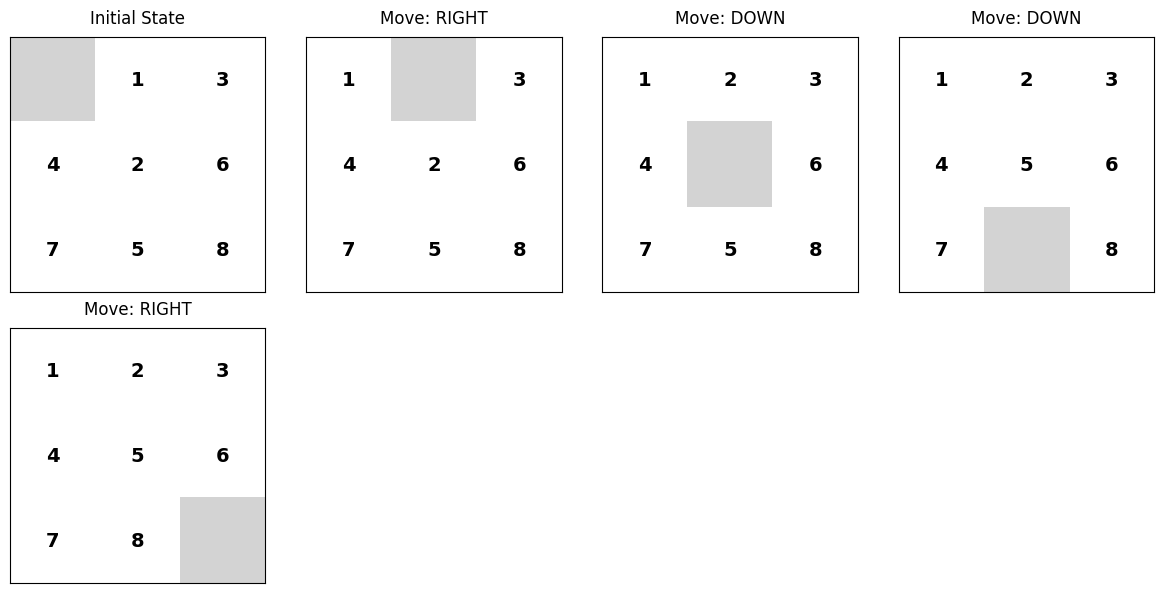

In [10]:
import numpy as np
import heapq
import matplotlib.pyplot as plt
from matplotlib import colors
import time

class PuzzleNode:
    def __init__(self, state, parent=None, action=None, cost=0):
        self.state = np.array(state)
        self.parent = parent
        self.action = action
        self.cost = cost
        self.h = self.manhattan_distance()
    
    def manhattan_distance(self):
        """Calculate Manhattan distance heuristic."""
        distance = 0
        for i in range(3):
            for j in range(3):
                if self.state[i][j] != 0:  # Skip empty tile
                    x_goal, y_goal = divmod(self.state[i][j] - 1, 3)
                    distance += abs(x_goal - i) + abs(y_goal - j)
        return distance
    
    def f(self):
        """Calculate f(n) = g(n) + h(n)."""
        return self.cost + self.h
    
    def __lt__(self, other):
        return self.f() < other.f()
    
    def __eq__(self, other):
        return np.array_equal(self.state, other.state)
    
    def __hash__(self):
        return hash(str(self.state))

class EightPuzzleSolver:
    def __init__(self, initial_state):
        self.initial_state = np.array(initial_state).reshape(3, 3)
        self.goal_state = np.array([[1, 2, 3], [4, 5, 6], [7, 8, 0]])
        self.moves = {
            'UP': (-1, 0),
            'DOWN': (1, 0),
            'LEFT': (0, -1),
            'RIGHT': (0, 1)
        }
        self.solution_path = []
        
    def is_solvable(self):
        """Check if the puzzle is solvable."""
        # Flatten the array and remove zero
        flat_state = self.initial_state.flatten()
        flat_state = flat_state[flat_state != 0]
        
        # Count inversions
        inversions = 0
        for i in range(len(flat_state)):
            for j in range(i + 1, len(flat_state)):
                if flat_state[i] > flat_state[j]:
                    inversions += 1
                    
        return inversions % 2 == 0
    
    def get_blank_position(self, state):
        """Find the position of the blank (0) tile."""
        return tuple(np.where(state == 0))
    
    def get_next_states(self, node):
        """Generate all possible next states from current state."""
        next_states = []
        blank_pos = self.get_blank_position(node.state)
        
        for action, (dx, dy) in self.moves.items():
            new_x, new_y = blank_pos[0] + dx, blank_pos[1] + dy
            
            if 0 <= new_x < 3 and 0 <= new_y < 3:
                new_state = node.state.copy()
                new_state[blank_pos], new_state[new_x, new_y] = \
                    new_state[new_x, new_y], new_state[blank_pos]
                next_states.append(
                    (PuzzleNode(new_state, node, action, node.cost + 1), action)
                )
        
        return next_states
    
    def solve(self):
        """Solve the puzzle using A* search."""
        if not self.is_solvable():
            print("This puzzle configuration is not solvable!")
            return False
            
        start_time = time.time()
        initial_node = PuzzleNode(self.initial_state)
        priority_queue = [(initial_node.f(), 0, initial_node)]  # Added counter for tiebreaking
        visited = {str(initial_node.state)}
        counter = 1
        nodes_expanded = 0
        
        while priority_queue:
            _, _, current_node = heapq.heappop(priority_queue)
            nodes_expanded += 1
            
            if np.array_equal(current_node.state, self.goal_state):
                # Build solution path
                path = []
                while current_node:
                    path.append((current_node, current_node.action))
                    current_node = current_node.parent
                self.solution_path = list(reversed(path))
                
                end_time = time.time()
                print(f"\nSolution found!")
                print(f"Time taken: {end_time - start_time:.3f} seconds")
                print(f"Number of moves: {len(self.solution_path) - 1}")
                print(f"Nodes expanded: {nodes_expanded}")
                return True
            
            for next_node, action in self.get_next_states(current_node):
                state_str = str(next_node.state)
                if state_str not in visited:
                    visited.add(state_str)
                    heapq.heappush(priority_queue, (next_node.f(), counter, next_node))
                    counter += 1
        
        print("No solution found!")
        return False
    
    def visualize_solution(self):
        """Visualize the solution path."""
        if not self.solution_path:
            print("No solution to visualize!")
            return
        
        n_steps = len(self.solution_path)
        rows = (n_steps + 3) // 4  # Ensure we have enough rows
        cols = min(4, n_steps)  # Maximum 4 puzzles per row
        
        fig, axes = plt.subplots(rows, cols, figsize=(cols * 3, rows * 3))
        if rows == 1 and cols == 1:
            axes = np.array([axes])
        axes = axes.flatten()
        
        # Create colormap for visualization
        cmap = colors.ListedColormap(['lightgray', 'white'])
        bounds = [-0.5, 0.5, 9.5]
        norm = colors.BoundaryNorm(bounds, cmap.N)
        
        for i, (node, action) in enumerate(self.solution_path):
            ax = axes[i]
            ax.imshow(node.state, cmap=cmap, norm=norm)
            
            # Add numbers and style
            for x in range(3):
                for y in range(3):
                    if node.state[x, y] != 0:
                        ax.text(y, x, str(int(node.state[x, y])), 
                               ha='center', va='center', fontsize=14, 
                               fontweight='bold', color='black')
            
            # Add move description
            if action:
                ax.set_title(f'Move: {action}', pad=10)
            else:
                ax.set_title('Initial State', pad=10)
            
            ax.grid(True, color='black', linewidth=1.5)
            ax.set_xticks([])
            ax.set_yticks([])
        
        # Remove empty subplots
        for i in range(len(self.solution_path), len(axes)):
            fig.delaxes(axes[i])
        
        plt.tight_layout()
        plt.show()

def main():
    # Example puzzle configuration
    # 0 represents the empty tile
    initial_state = [
        [0, 1, 3],
        [4, 2, 6],
        [7, 5, 8]
    ]
    
    # Create solver instance
    solver = EightPuzzleSolver(initial_state)
    
    # Check if puzzle is solvable
    if solver.is_solvable():
        print("Solving puzzle...")
        if solver.solve():
            solver.visualize_solution()
    else:
        print("This puzzle configuration is not solvable!")

if __name__ == "__main__":
    main()